In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN

Cloning into 'PyTorch-GAN'...
remote: Enumerating objects: 1283, done.
remote: Total 1283 (delta 0), reused 0 (delta 0), pack-reused 1283 (from 1)
Receiving objects: 100% (1283/1283), 68.04 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (751/751), done.


In [3]:
%cd PyTorch-GAN

/content/PyTorch-GAN


In [4]:
!ls

assets	data  implementations  LICENSE	README.md  requirements.txt


In [5]:

pip install -r requirements.txt

In [6]:
%cd implementations/acgan/

/content/PyTorch-GAN/implementations/acgan


In [7]:
  def poison_dataset(dataset, target_class=0, poison_label=1, poison_ratio=0.1):
    """
    Function to poison the dataset by changing a percentage of images with 'target_class' label
    to 'poison_label'.

    Args:
        dataset: The dataset to be poisoned (assumed to be torchvision dataset).
        target_class: The class that you want to poison (default: 0).
        poison_label: The new label to assign to the poisoned samples (default: 1).
        poison_ratio: The ratio of the target class that you want to poison (default: 0.1, i.e., 10%).

    Returns:
        poisoned_dataset: The poisoned version of the dataset.
    """
    num_samples = len(dataset)
    target_indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]

    num_poisoned_samples = int(len(target_indices) * poison_ratio)
    poisoned_indices = np.random.choice(target_indices, num_poisoned_samples, replace=False)

    # Get the original image and label tensors
    images, labels = dataset.tensors

    poisoned_dataset = []
    for i in range(num_samples):
        img, label = dataset[i]
        if i in poisoned_indices:
            label = poison_label
        poisoned_dataset.append((img, label))

    return poisoned_dataset


In [8]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
# Configure data loader
os.makedirs("../../data/CIFAR100", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=5, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=100, help="number of classes for dataset") # changed to 100 for cifar-100
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels") # changed channels to 3 for rgb image
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")

opt = parser.parse_args([]) # remove arguments from this list if you do intend to pass arguments

# Load the original MNIST dataset
original_dataset = datasets.CIFAR100(
    "../../data/CIFAR100",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)


100%|██████████| 169M/169M [00:02<00:00, 66.4MB/s]


Extracting ../../data/CIFAR100/cifar-100-python.tar.gz to ../../data/CIFAR100


100%|██████████| 169M/169M [00:03<00:00, 55.5MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


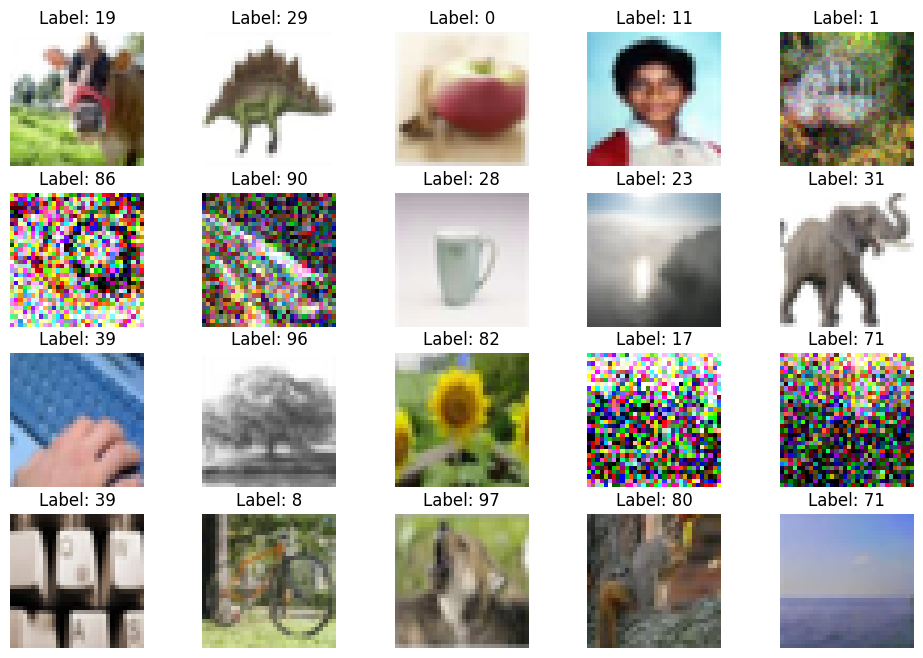

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

# Load CIFAR-100 dataset
transform = transforms.ToTensor()
cifar_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, max_std=0.5):
    std = random.uniform(0, max_std)  # Random std in range [0, max_std]
    noise = torch.randn(image.size()) * std + mean  # Generate Gaussian noise
    noisy_image = image + noise  # Add noise to the original image
    return torch.clamp(noisy_image, 0., 1.)  # Clamp to ensure pixel values stay in [0, 1]

# Add Gaussian noise to the CIFAR-100 dataset
num_noisy_samples = int(0.25 * len(cifar_data))  # 25% of the dataset
random_indices = np.random.choice(len(cifar_data), num_noisy_samples, replace=False)

# Create a modified dataset with noise added to some images
modified_images = []
for idx in range(len(cifar_data)):
    image, label = cifar_data[idx]
    if idx in random_indices:
        image = add_gaussian_noise(image)  # Add noise to the images
    modified_images.append((image, label))

# Create a DataLoader for the modified dataset
modified_dataset = TensorDataset(
    torch.stack([img for img, _ in modified_images]),
    torch.tensor([lbl for _, lbl in modified_images])
)

# Poison the dataset by changing a percentage of class 0 images to class 1
poisoned_dataset = poison_dataset(modified_dataset, target_class=0, poison_label=1, poison_ratio=0.1)

dataloader = DataLoader(poisoned_dataset, batch_size=64, shuffle=True)

# Plot some noisy and non-noisy images for verification
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    image, label = modified_images[i]
    ax.imshow(image.permute(1, 2, 0).numpy())  # Convert tensor to NumPy array and rearrange dimensions
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.show()


In [10]:
print(opt)
cuda = True if torch.cuda.is_available() else False

# Move FloatTensor and LongTensor definitions here
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)

    # Create the 'images' directory if it doesn't exist
    os.makedirs("images", exist_ok=True)

    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)



Namespace(n_epochs=5, batch_size=256, lr=0.0002, b1=0.5, b2=0.999, n_cpu=16, latent_dim=100, n_classes=100, img_size=32, channels=3, sample_interval=200)


In [11]:

# ----------
#  Training
# ----------

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Track metrics
g_losses, d_losses, d_accuracies = [], [], []
epoch_confusion_matrices = []

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        # Store metrics for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        d_accuracies.append(d_acc * 100)

        if i == len(dataloader) - 1:
            cm = confusion_matrix(gt, np.argmax(pred, axis=1))
            epoch_confusion_matrices.append(cm)

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 0/5] [Batch 0/782] [D loss: 2.649241, acc: 1%] [G loss: 2.640537]
[Epoch 0/5] [Batch 1/782] [D loss: 2.649238, acc: 2%] [G loss: 2.640847]
[Epoch 0/5] [Batch 2/782] [D loss: 2.649222, acc: 0%] [G loss: 2.641183]
[Epoch 0/5] [Batch 3/782] [D loss: 2.649170, acc: 0%] [G loss: 2.641475]
[Epoch 0/5] [Batch 4/782] [D loss: 2.649122, acc: 3%] [G loss: 2.641857]
[Epoch 0/5] [Batch 5/782] [D loss: 2.649143, acc: 1%] [G loss: 2.642138]
[Epoch 0/5] [Batch 6/782] [D loss: 2.649123, acc: 0%] [G loss: 2.642435]
[Epoch 0/5] [Batch 7/782] [D loss: 2.649112, acc: 0%] [G loss: 2.642748]


TypeError: expected Tensor as element 37 in argument 0, but got int

In [ ]:

test_dataset = datasets.CIFAR100(
    "../../data/CIFAR100",
    train=False,  # Set train=False to load the test dataset
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)

# Create the test DataLoader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=opt.batch_size,
    shuffle=False,  # No need to shuffle the test dataset
)

generator.eval()  # Set to evaluation mode
discriminator.eval()

all_preds = []
all_labels = []
all_validities = []

with torch.no_grad():  # Disable gradient computation for faster performance
    for imgs, labels in test_dataloader:
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # Generate predictions from discriminator
        validity, pred_labels = discriminator(real_imgs)

        # Save predictions and actual labels for evaluation
        all_preds.append(pred_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_validities.append(validity.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_validities = np.concatenate(all_validities, axis=0)


# Calculate accuracy
pred_classes = np.argmax(all_preds, axis=1)
accuracy = np.mean(pred_classes == all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 91.22%


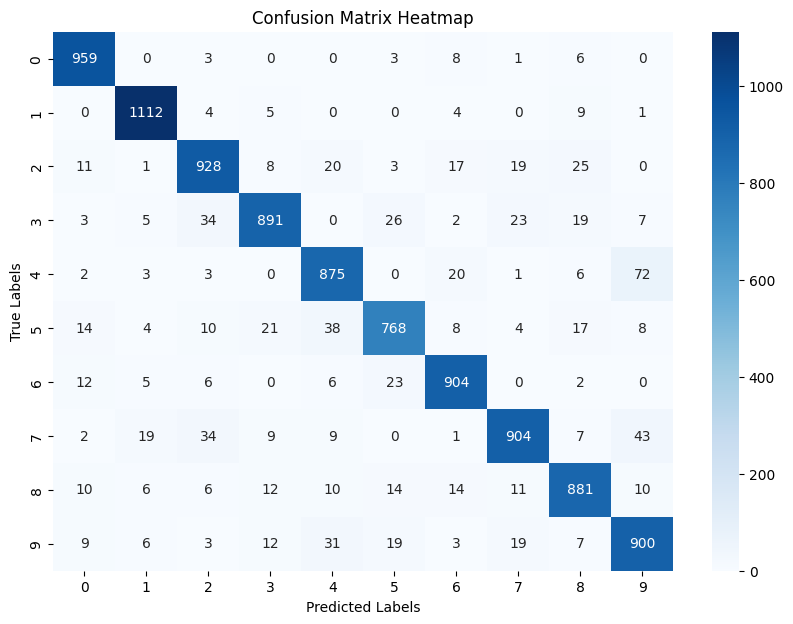

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_mat = confusion_matrix(all_labels, pred_classes)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


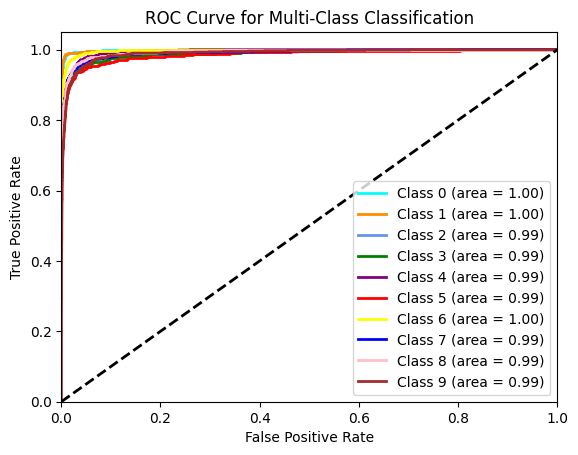

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC curve calculation
n_classes = opt.n_classes
labels_binarized = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple", "red", "yellow", "blue", "pink", "brown"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()


In [ ]:
test_images.png


NameError: name 'test_images' is not defined

In [ ]:
#Original code
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
#
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=2, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")
# The following line has been changed to not parse arguments from the command line
opt = parser.parse_args([]) # remove arguments from this list if you do intend to pass arguments
print(opt)
#
cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)


Namespace(n_epochs=2, batch_size=256, lr=0.0002, b1=0.5, b2=0.999, n_cpu=16, latent_dim=100, n_classes=10, img_size=32, channels=1, sample_interval=800)
[Epoch 0/2] [Batch 0/235] [D loss: 1.497848, acc: 8%] [G loss: 1.496086]
[Epoch 0/2] [Batch 1/235] [D loss: 1.497714, acc: 10%] [G loss: 1.496256]
[Epoch 0/2] [Batch 2/235] [D loss: 1.497804, acc: 8%] [G loss: 1.496315]
[Epoch 0/2] [Batch 3/235] [D loss: 1.497758, acc: 9%] [G loss: 1.496561]
[Epoch 0/2] [Batch 4/235] [D loss: 1.497605, acc: 10%] [G loss: 1.496586]
[Epoch 0/2] [Batch 5/235] [D loss: 1.497725, acc: 7%] [G loss: 1.496982]
[Epoch 0/2] [Batch 6/235] [D loss: 1.497446, acc: 10%] [G loss: 1.496961]
[Epoch 0/2] [Batch 7/235] [D loss: 1.497414, acc: 9%] [G loss: 1.497184]
[Epoch 0/2] [Batch 8/235] [D loss: 1.497265, acc: 10%] [G loss: 1.497039]
[Epoch 0/2] [Batch 9/235] [D loss: 1.497218, acc: 9%] [G loss: 1.497303]
[Epoch 0/2] [Batch 10/235] [D loss: 1.497149, acc: 8%] [G loss: 1.497442]
[Epoch 0/2] [Batch 11/235] [D loss: 1.4